In [1]:
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn        #for all Neural Network stuff
import torch.optim as optim  #for all optimizer stuff

In [2]:
#method argument not needed??
data_size = 1000 #number of points in linspace
batch_time = 500
batch_size = 250
niters = 2000 #number of iterations
test_freq = 1
viz = True
gpu = 1
adjoint = True

In [3]:
from torchdiffeq import odeint_adjoint as odeint

In [4]:
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [5]:
#initial conditions; requires 2D tensor
true_y0 = torch.tensor([[2.0,1.0]])
#create linspace like usual
t = torch.linspace(0.0, 40.0, data_size)
#creates a system of differential equations for dy and dx
true_A = torch.tensor([[-0.1,2.0],[-2.0, -0.1]]) # will generate 2 right hand side second order DE's

In [6]:
#lambda is a nn.Module like Linear, Conv2D etc,,
class Lambda(nn.Module):
    def forward(self,t,y):
        return torch.mm(y,true_A) #< is the same as below
        #return torch.tensor([-0.1*y[:,0]**3-2*y[:,1]**3,2*y[:,0]**3-0.1*y[:,1]**3])  #starting with true_y0 it does mxn X nxp -> mxp

In [7]:
with torch.no_grad(): #no_grad disables gradient finding when true_y is defined
    #print(torch.mm(true_y0**3,true_A))
    true_y = odeint(Lambda(),true_y0, t, method='adams') 
#true_y is the solved ODE defined in Lambda
#odeint only takes a function from nn.Module >> implications? see solver comparision Jupyter
#it uses Lambda to provide the function to go solve the IVP given true_y0 with the ODE solver on t

In [8]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), batch_size, replace=False))
#s is a torch tensor from a numpy array. the array is a random choice array, a rand number from 0 to ds-bt is chosen bs times.
#s has batch_size elements and each was equally likely to be chosen
#why ds-bt? why not just data_size as a rance since we are chosing from the t linspace with ds many points?
    batch_y0 = true_y[s] #(M, D) <- idk what this means
#b_y0 is made of the randomly selected data points (dep vals) from true_y solution
    batch_t = t[:batch_time] #(T)
#b_t is the values rank 0 to b_time from your linspace t; the linspace values being looked at
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)],dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [9]:
def visualize(true_y, pred_y):
    plt.plot(t.numpy(),true_y.numpy()[:, 0, 0],'b',t.numpy(),pred_y.numpy()[:, 0, 0],'g--')
    plt.plot(t.numpy(),true_y.numpy()[:, 0, 1],'b',t.numpy(),pred_y.numpy()[:, 0, 1],'r--')
    plt.xlim(-1,40)
    plt.ylim(-2,2)
    plt.show()

In [10]:
class ODEFunc(nn.Module): #create an ODE block as our neural network. usually multiple layers/modules
    
    def __init__(self):
        super(ODEFunc, self).__init__()
#self.net is the neural network layers one after the other L -> T -> L        
        self.net = nn.Sequential(    
            nn.Linear(2,100),
            nn.Tanh(),
            nn.Linear(100,2),
        )
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear): #checks in the module m in self.net is an instance of the nn.Linear class
                nn.init.normal_(m.weight, mean=0, std=0.1) #for the Linear modules make all the weights randn with std 0.1
                nn.init.constant_(m.bias, val=0) #for the Linear modules make all the bias vector values 0
    
    def forward(self, t, y):
        return self.net(y) #essentially Lambda.forward(args) without the true_A >>>which is TBD<<<

In [11]:
class RunningAverageMeter(object): #Computes and stores the average and current value
    def __init__(self, momentum=0.99): #new object of this class will have mom of 0.99 and a reset val and avg
        self.momentum = momentum
        self.reset()
    def reset(self):                   #reset function called to set val and avg to None and 0 respectively
        self.val = None
        self.avg = 0
    def update(self, val):             #update is called externally to update the avg based on val
        if self.val is None:
            self.avg = val
        else:
            self.avg = (self.avg * self.momentum) + (val * (1 - self.momentum)) #reminds me of output error at L

Iteration 0001 | Total Loss 0.447270


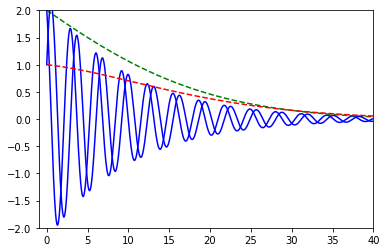

Iteration 0002 | Total Loss 0.273819


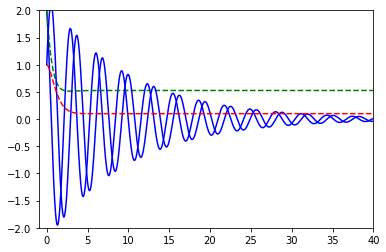

Iteration 0003 | Total Loss 0.162448


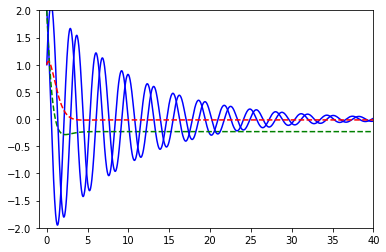

Iteration 0004 | Total Loss 0.151895


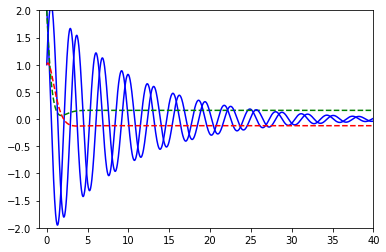

Iteration 0005 | Total Loss 0.158002


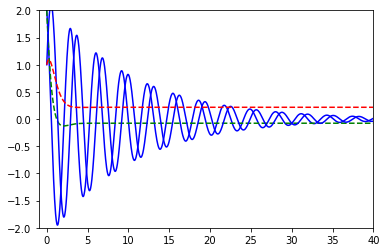

Iteration 0006 | Total Loss 0.146709


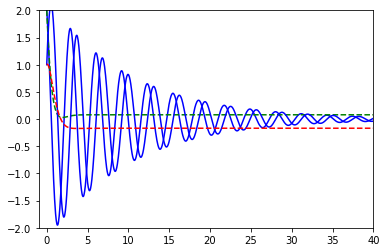

Iteration 0007 | Total Loss 0.137240


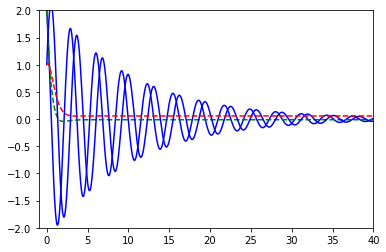

Iteration 0008 | Total Loss 0.139047


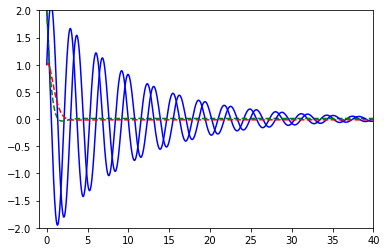

Iteration 0009 | Total Loss 0.125374


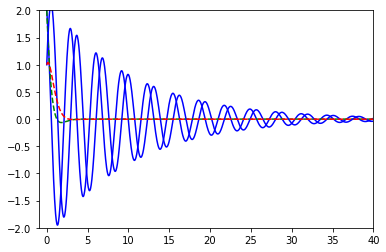

Iteration 0010 | Total Loss 0.133981


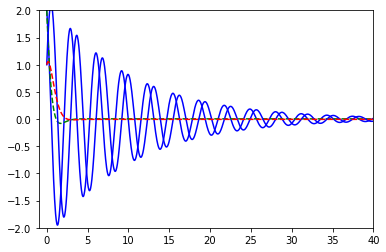

Iteration 0011 | Total Loss 0.120206


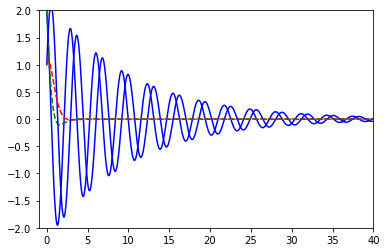

Iteration 0012 | Total Loss 0.144175


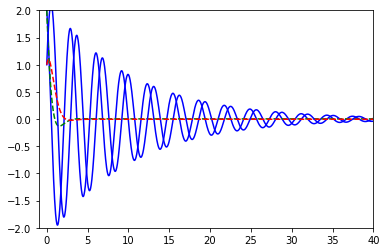

Iteration 0013 | Total Loss 0.135743


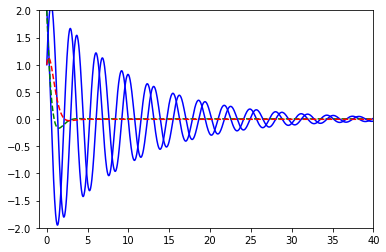

Iteration 0014 | Total Loss 0.132170


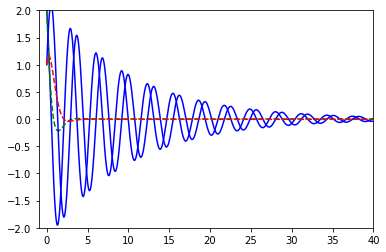

Iteration 0015 | Total Loss 0.126538


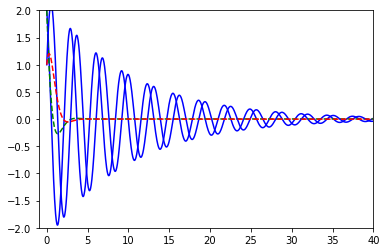

Iteration 0016 | Total Loss 0.131147


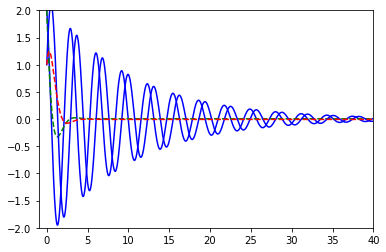

Iteration 0017 | Total Loss 0.111824


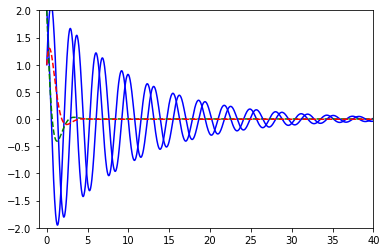

Iteration 0018 | Total Loss 0.114576


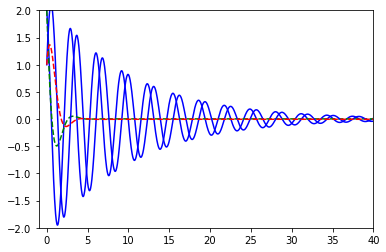

Iteration 0019 | Total Loss 0.112243


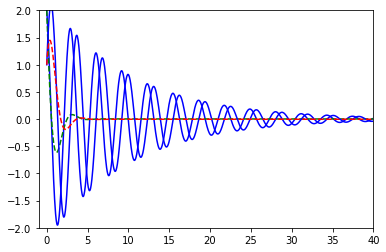

Iteration 0020 | Total Loss 0.118158


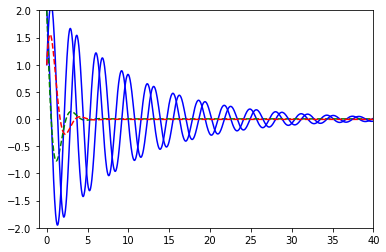

Iteration 0021 | Total Loss 0.105948


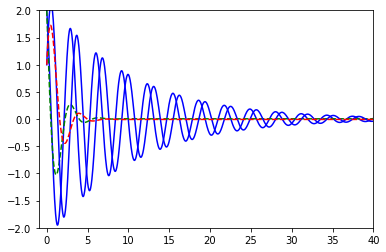

Iteration 0022 | Total Loss 0.089691


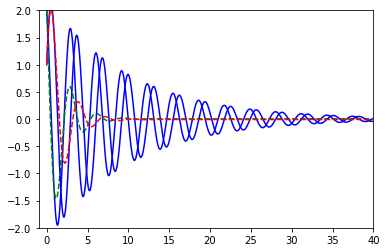

Iteration 0023 | Total Loss 0.035416


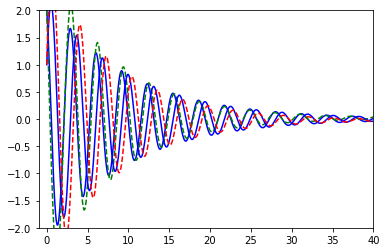

Iteration 0024 | Total Loss 0.125569


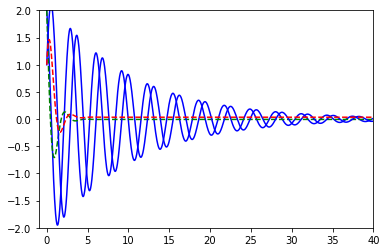

Iteration 0025 | Total Loss 0.115205


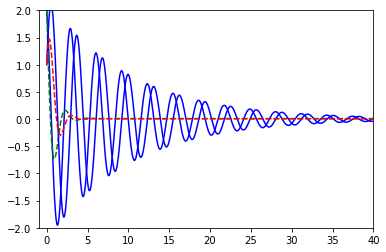

Iteration 0026 | Total Loss 0.106245


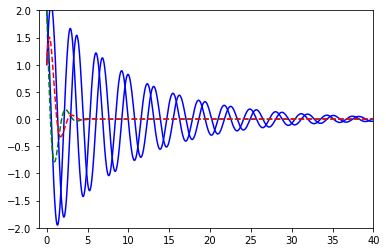

Iteration 0027 | Total Loss 0.117452


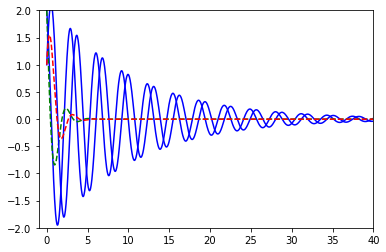

Iteration 0028 | Total Loss 0.109802


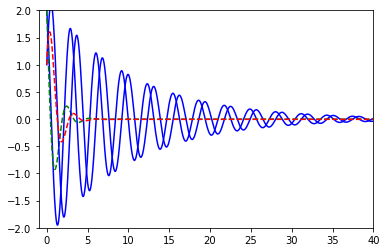

Iteration 0029 | Total Loss 0.098182


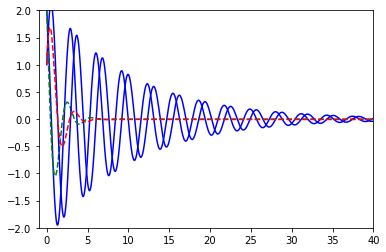

Iteration 0030 | Total Loss 0.095684


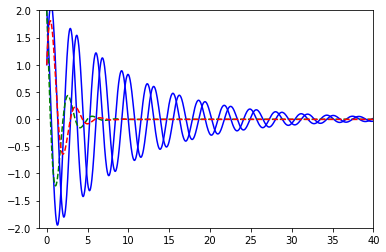

Iteration 0031 | Total Loss 0.078558


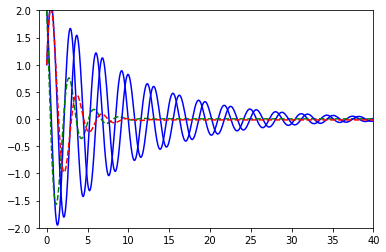

Iteration 0032 | Total Loss 0.053042


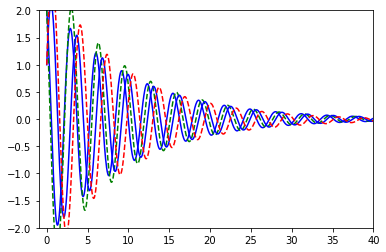

Iteration 0033 | Total Loss 0.136121


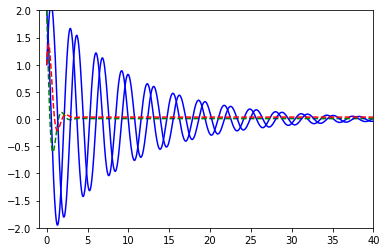

Iteration 0034 | Total Loss 0.131598


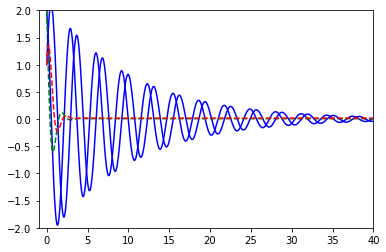

Iteration 0035 | Total Loss 0.137829


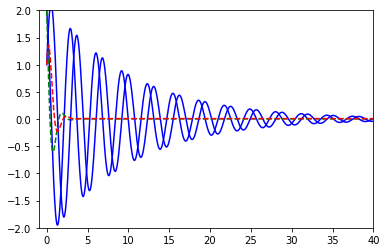

Iteration 0036 | Total Loss 0.134786


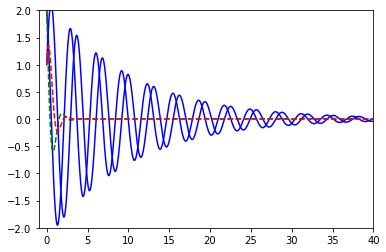

Iteration 0037 | Total Loss 0.146096


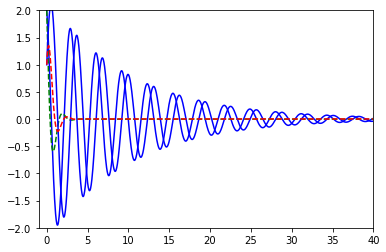

Iteration 0038 | Total Loss 0.132036


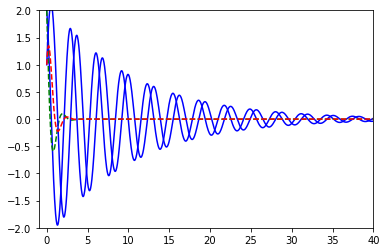

Iteration 0039 | Total Loss 0.141274


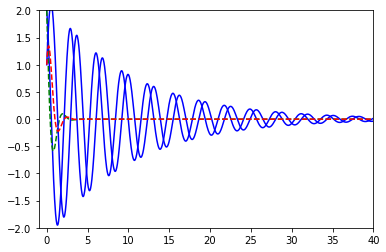

Iteration 0040 | Total Loss 0.139665


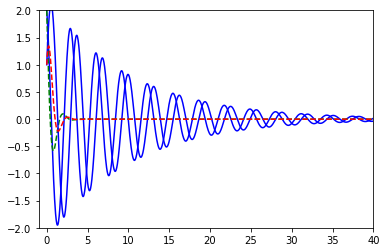

Iteration 0041 | Total Loss 0.117702


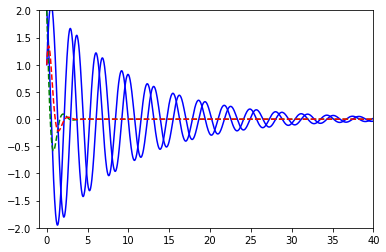

Iteration 0042 | Total Loss 0.132215


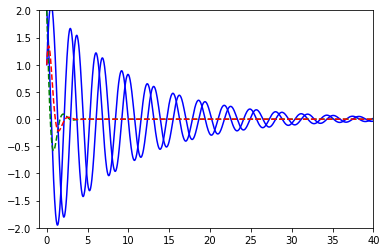

Iteration 0043 | Total Loss 0.123789


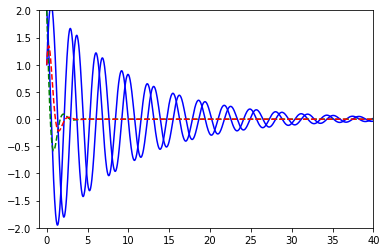

Iteration 0044 | Total Loss 0.121166


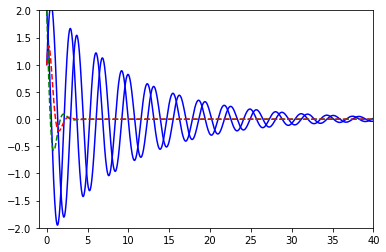

Iteration 0045 | Total Loss 0.117093


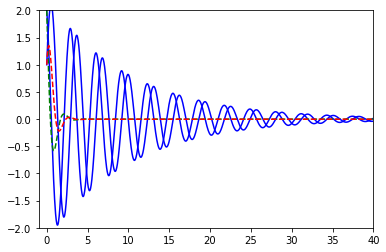

Iteration 0046 | Total Loss 0.121976


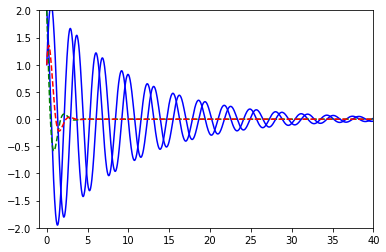

Iteration 0047 | Total Loss 0.133266


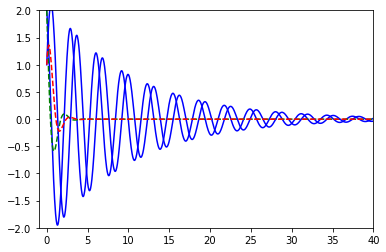

Iteration 0048 | Total Loss 0.111507


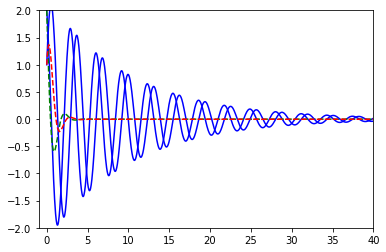

Iteration 0049 | Total Loss 0.119632


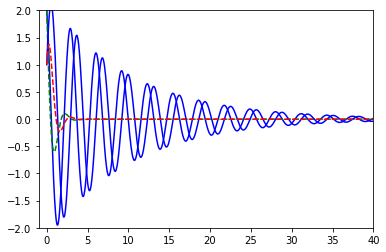

Iteration 0050 | Total Loss 0.131656


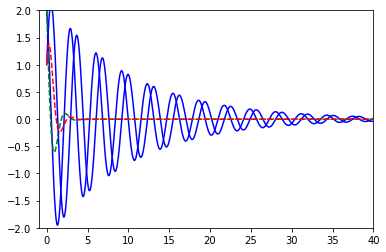

Iteration 0051 | Total Loss 0.117909


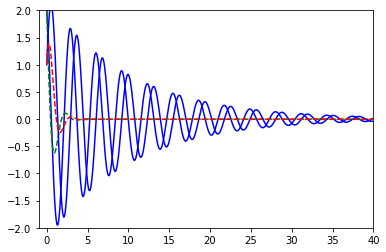

Iteration 0052 | Total Loss 0.117852


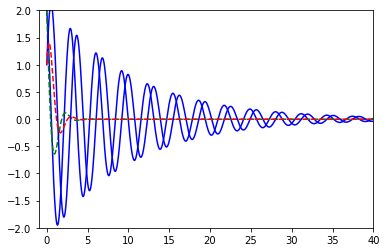

Iteration 0053 | Total Loss 0.128113


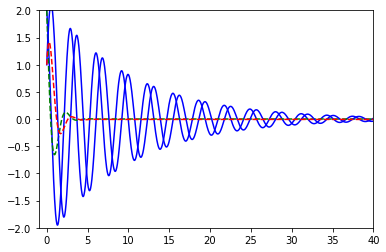

Iteration 0054 | Total Loss 0.113503


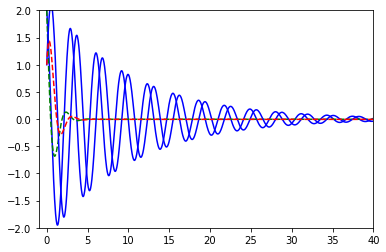

Iteration 0055 | Total Loss 0.107326


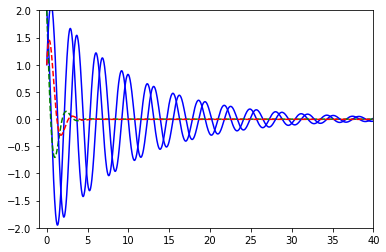

Iteration 0056 | Total Loss 0.114464


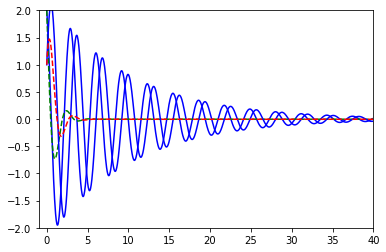

Iteration 0057 | Total Loss 0.110990


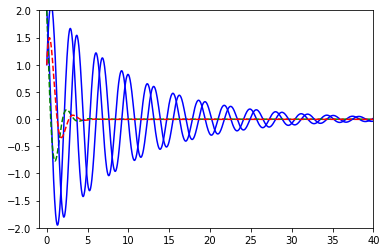

Iteration 0058 | Total Loss 0.105496


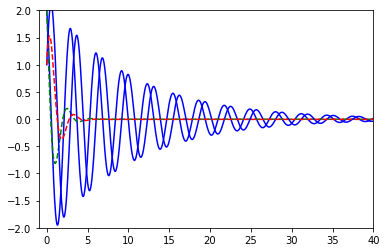

Iteration 0059 | Total Loss 0.114216


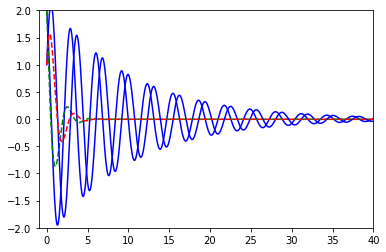

Iteration 0060 | Total Loss 0.103963


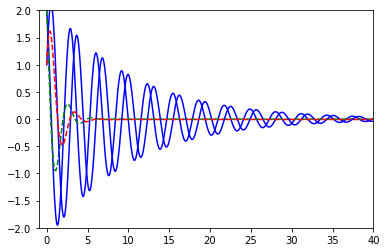

Iteration 0061 | Total Loss 0.094874


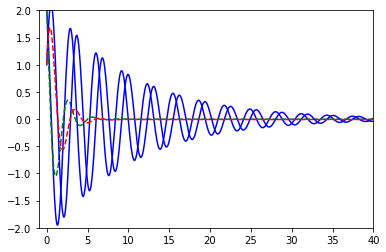

Iteration 0062 | Total Loss 0.077792


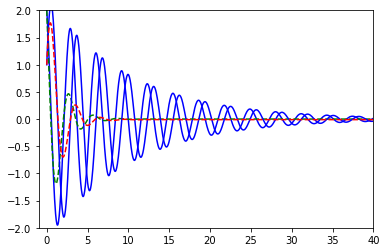

Iteration 0063 | Total Loss 0.079032


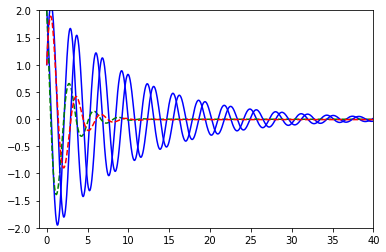

Iteration 0064 | Total Loss 0.043337


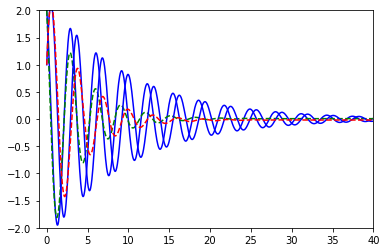

Iteration 0065 | Total Loss 17.868811


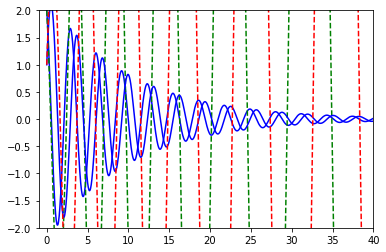

Iteration 0066 | Total Loss 0.157019


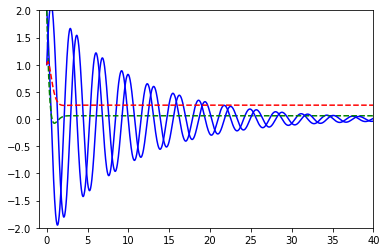

Iteration 0067 | Total Loss 0.160441


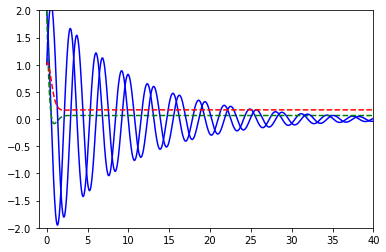

Iteration 0068 | Total Loss 0.126189


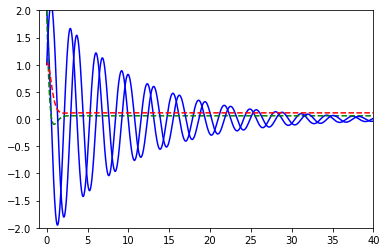

Iteration 0069 | Total Loss 0.150452


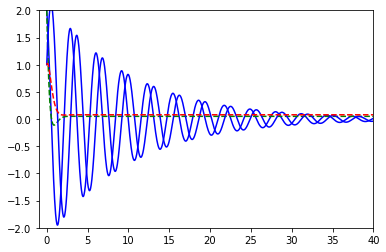

Iteration 0070 | Total Loss 0.133020


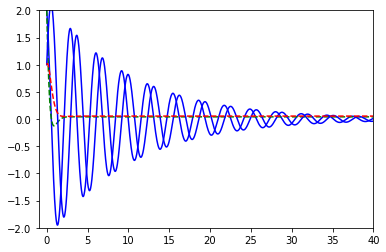

Iteration 0071 | Total Loss 0.139054


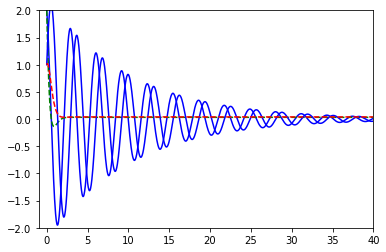

Iteration 0072 | Total Loss 0.139356


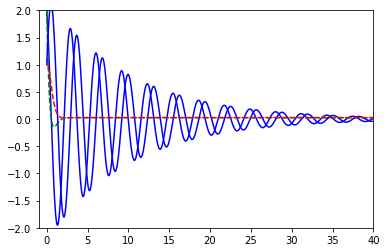

Iteration 0073 | Total Loss 0.131822


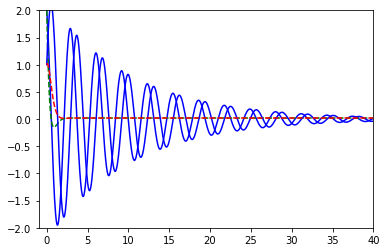

Iteration 0074 | Total Loss 0.133694


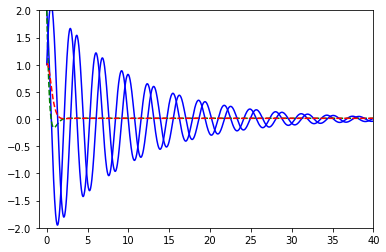

Iteration 0075 | Total Loss 0.139029


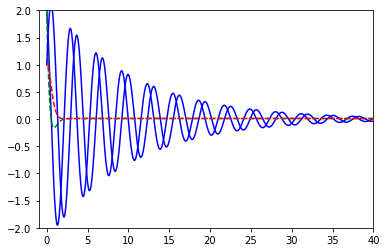

Iteration 0076 | Total Loss 0.133241


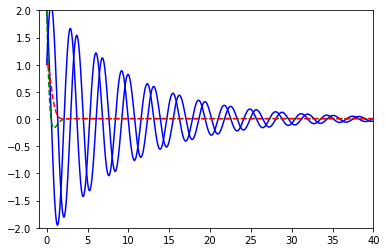

Iteration 0077 | Total Loss 0.126601


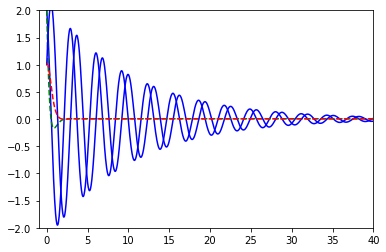

Iteration 0078 | Total Loss 0.134999


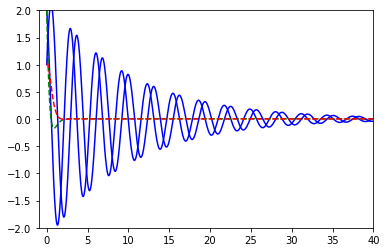

Iteration 0079 | Total Loss 0.129341


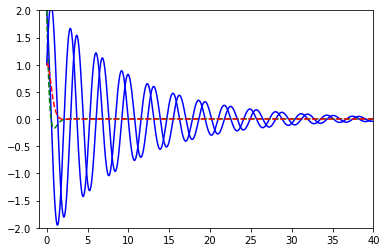

Iteration 0080 | Total Loss 0.135984


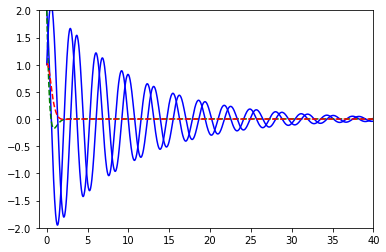

Iteration 0081 | Total Loss 0.126776


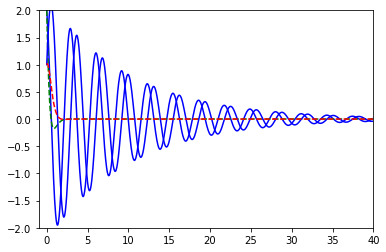

Iteration 0082 | Total Loss 0.125370


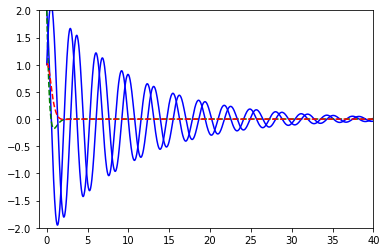

Iteration 0083 | Total Loss 0.135522


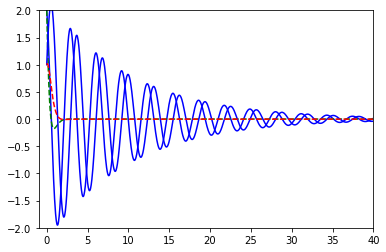

Iteration 0084 | Total Loss 0.138038


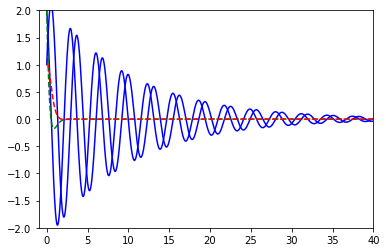

Iteration 0085 | Total Loss 0.136480


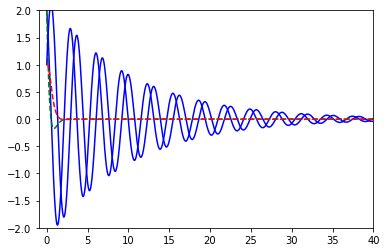

Iteration 0086 | Total Loss 0.127122


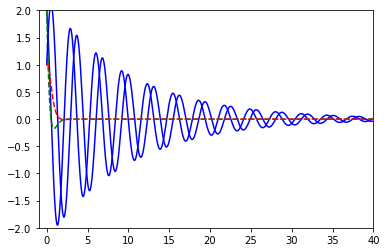

Iteration 0087 | Total Loss 0.130794


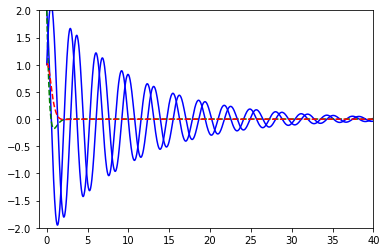

Iteration 0088 | Total Loss 0.138731


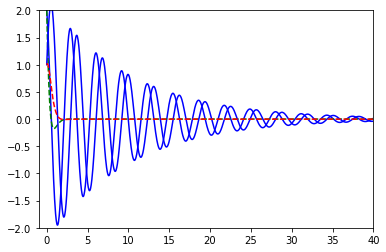

Iteration 0089 | Total Loss 0.123239


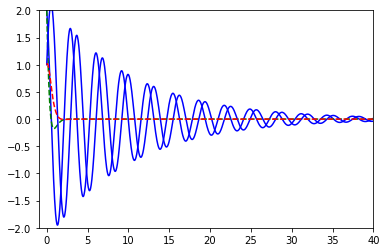

Iteration 0090 | Total Loss 0.130976


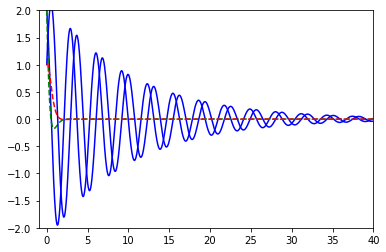

Iteration 0091 | Total Loss 0.136372


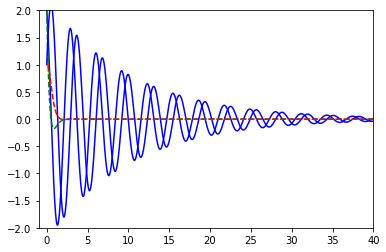

Iteration 0092 | Total Loss 0.145726


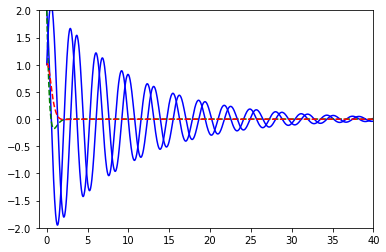

Iteration 0093 | Total Loss 0.136171


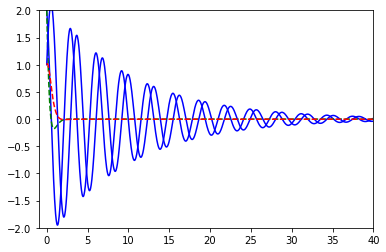

Iteration 0094 | Total Loss 0.131487


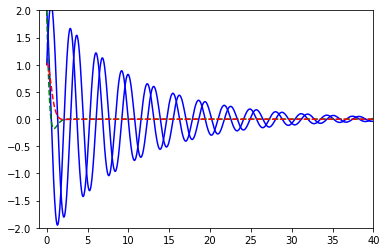

Iteration 0095 | Total Loss 0.129551


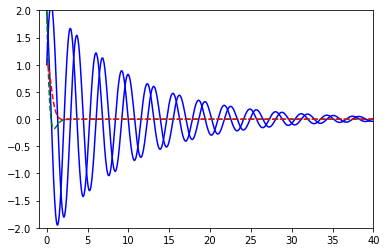

Iteration 0096 | Total Loss 0.129862


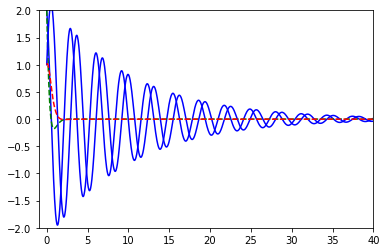

Iteration 0097 | Total Loss 0.133955


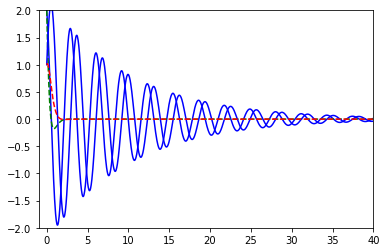

Iteration 0098 | Total Loss 0.132543


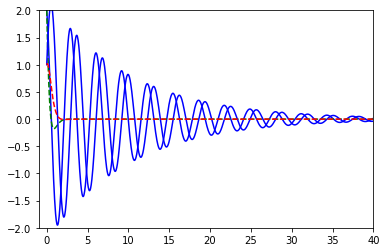

Iteration 0099 | Total Loss 0.131784


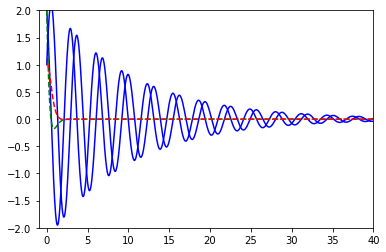

Iteration 0100 | Total Loss 0.130668


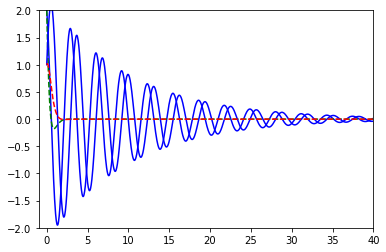

In [ ]:
if __name__ == '__main__':
    
    ii = 0
    
    func = ODEFunc()
    optimizer = optim.RMSprop(func.parameters())          #this is an optimizer designed to update parameters
    end = time.time()                                     #usually people use SGD but this is a mini-batch approach
                                                          #http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
    #RunningAvgMeter Objects
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    #TRAINING
    for itr in range(1, niters+1):
        optimizer.zero_grad() #set gradients to zero/ not computed
        batch_y0, batch_t, batch_y = get_batch()
        #feeds odeint the ODEBlock, a set of y values based on random t values and the first ten values of t
        pred_y = odeint(func, batch_y0, batch_t)
        #deviates from usual Loss of mean squared difference but sum in both cases is positive
        loss = torch.mean(torch.abs(pred_y-batch_y)**2) #ask Ivan about predY-bY, also this returns a number

        print('Iteration {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        pred_y = odeint(func, true_y0, t)
        visualize(true_y.detach(),pred_y.detach())
        
        loss.backward() #backpropogation
        optimizer.step() #gradient descent and update parameters
    
        #Update time and loss meters
        time_meter.update(time.time()-end) #takes in time difference to establish velocity see RMS method details
        loss_meter.update(loss.item()) #the loss itself is a delta / change
    
        ii+=1
        #print to screen and graph progress
        #if itr % test_freq == 0:
            #with torch.no_grad(): #no updating in here, no GD
                #pred_y = odeint(func, true_y0, t) #use trained func with true IVP
                #loss = torch.mean(torch.abs(pred_y-true_y)) #compare prediction to true function
                #print('Iteration {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                #visualize(true_y,pred_y)
                
        end = time.time()